# MOBPY Example: Insurance Charges Analysis
This notebook demonstrates monotonic optimal binning on the Insurance dataset with a continuous target variable (charges).

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Import MOBPY components
from MOBPY import MonotonicBinner, BinningConstraints
from MOBPY.plot import (
    plot_bin_statistics, plot_pava_comparison, plot_pava_process,
    plot_event_rate, plot_sample_distribution,
    plot_bin_boundaries, plot_gcm
)
from MOBPY.core.merge import MergeStrategy

# Set style and random seed
plt.style.use('seaborn-v0_8-darkgrid')
np.random.seed(42)

##### 1. Load and Explore the Insurance Dataset

In [2]:
# Load the insurance dataset
df = pd.read_csv('/Users/chentahung/Desktop/git/mob-py/data/insurance3r2.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumn information:")
print(df.dtypes)
print(f"\nTarget (charges) statistics:")
print(df['charges'].describe())

Dataset shape: (1338, 9)

Column information:
age                 int64
sex                 int64
bmi               float64
steps               int64
children            int64
smoker              int64
region              int64
charges           float64
insuranceclaim      int64
dtype: object

Target (charges) statistics:
count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64


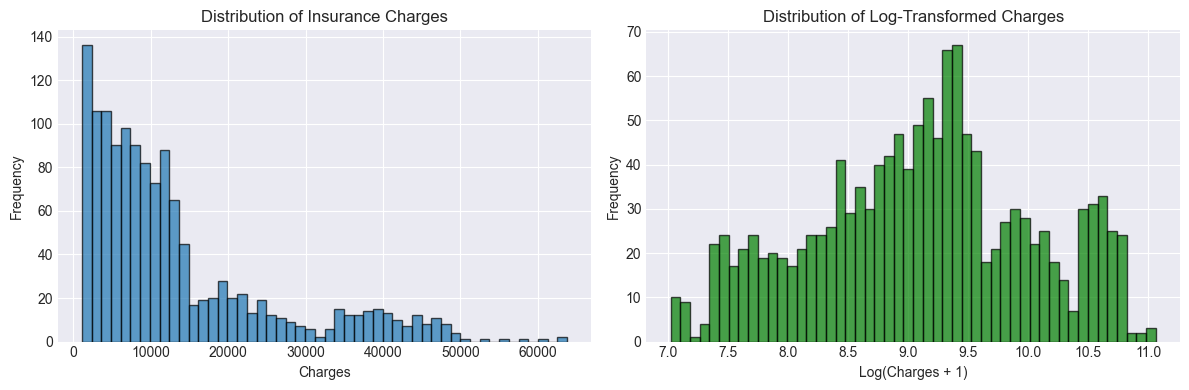

In [3]:
# Visualize the target distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Histogram
ax1.hist(df['charges'], bins=50, edgecolor='black', alpha=0.7)
ax1.set_xlabel('Charges')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Insurance Charges')

# Log-scale histogram
ax2.hist(np.log1p(df['charges']), bins=50, edgecolor='black', alpha=0.7, color='green')
ax2.set_xlabel('Log(Charges + 1)')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Log-Transformed Charges')

plt.tight_layout()
plt.show()

##### 2. Feature Relationships with Target

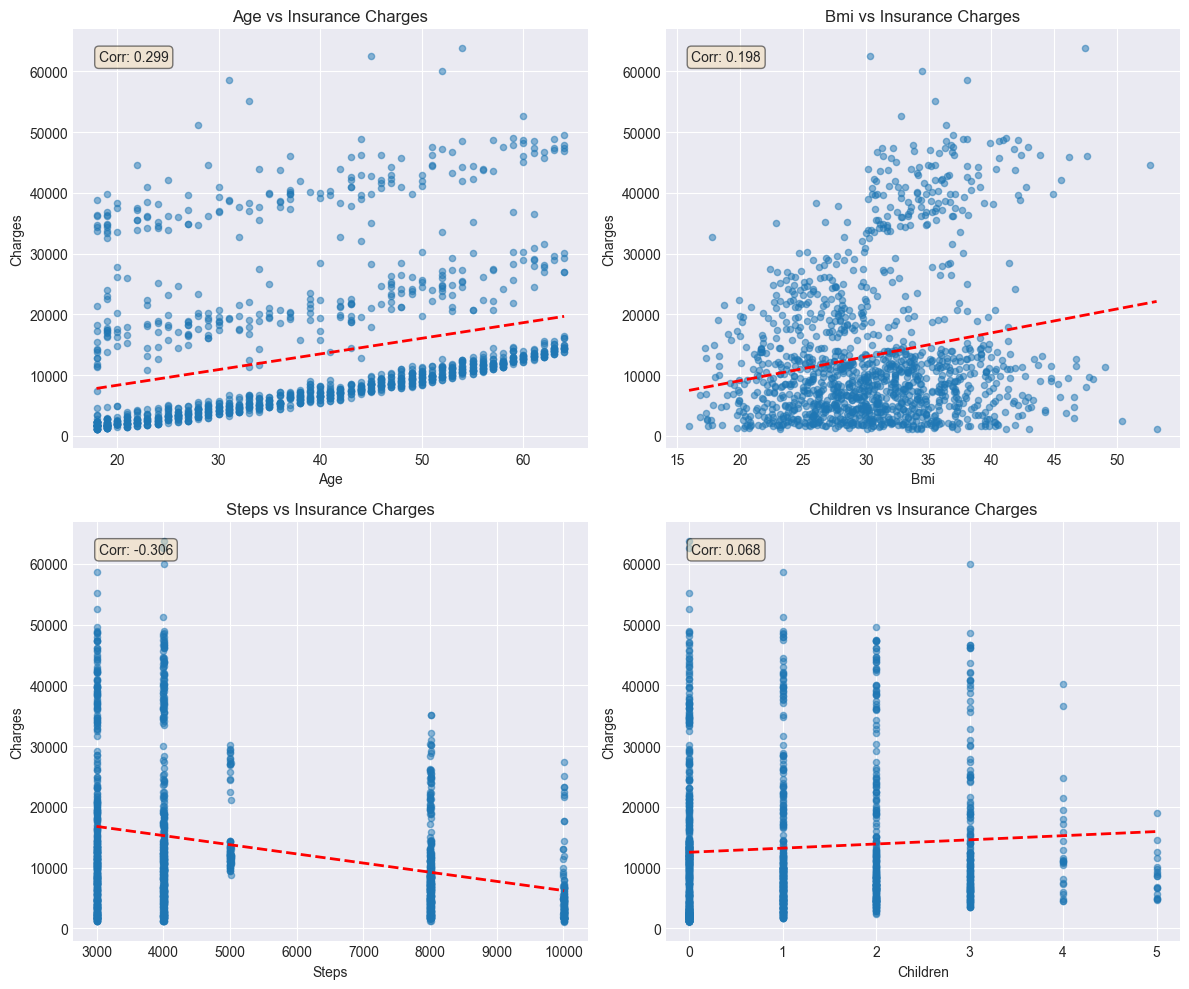

In [4]:
# Examine relationships between features and charges
numeric_features = ['age', 'bmi', 'steps', 'children']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, feature in enumerate(numeric_features):
    ax = axes[idx]
    
    # Scatter plot with trend line
    ax.scatter(df[feature], df['charges'], alpha=0.5, s=20)
    
    # Add trend line
    z = np.polyfit(df[feature], df['charges'], 1)
    p = np.poly1d(z)
    ax.plot(sorted(df[feature]), p(sorted(df[feature])), "r--", linewidth=2)
    
    ax.set_xlabel(feature.capitalize())
    ax.set_ylabel('Charges')
    ax.set_title(f'{feature.capitalize()} vs Insurance Charges')
    
    # Add correlation
    corr = df[feature].corr(df['charges'])
    ax.text(0.05, 0.95, f'Corr: {corr:.3f}', transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

##### 3. Monotonic Binning: BMI Example

In [5]:
# Create constraints for continuous target
constraints = BinningConstraints(
    max_bins=6,
    min_bins=3,
    min_samples=0.05,      # At least 5% of data per bin
    max_samples=0.40,      # No more than 40% in any bin
    initial_pvalue=0.4,
    maximize_bins=False
)

# Fit the binner
bmi_binner = MonotonicBinner(
    df=df,
    x='bmi',
    y='charges',
    constraints=constraints,
    sign='auto',
    strict=True
)

bmi_binner.fit()

print(f"Monotonicity direction: {bmi_binner.resolved_sign_}")
print(f"Number of bins created: {len(bmi_binner.bins_())}")

2025-08-27 22:48:30 - MOBPY.core.merge - WARNING - Could not satisfy min_samples for 2 bins (reached min_bins=3 limit)
Monotonicity direction: +
Number of bins created: 4


##### 3.1 Understanding PAVA Process
The Greatest Convex Minorant shows how PAVA creates monotonic bins from continuous target data:

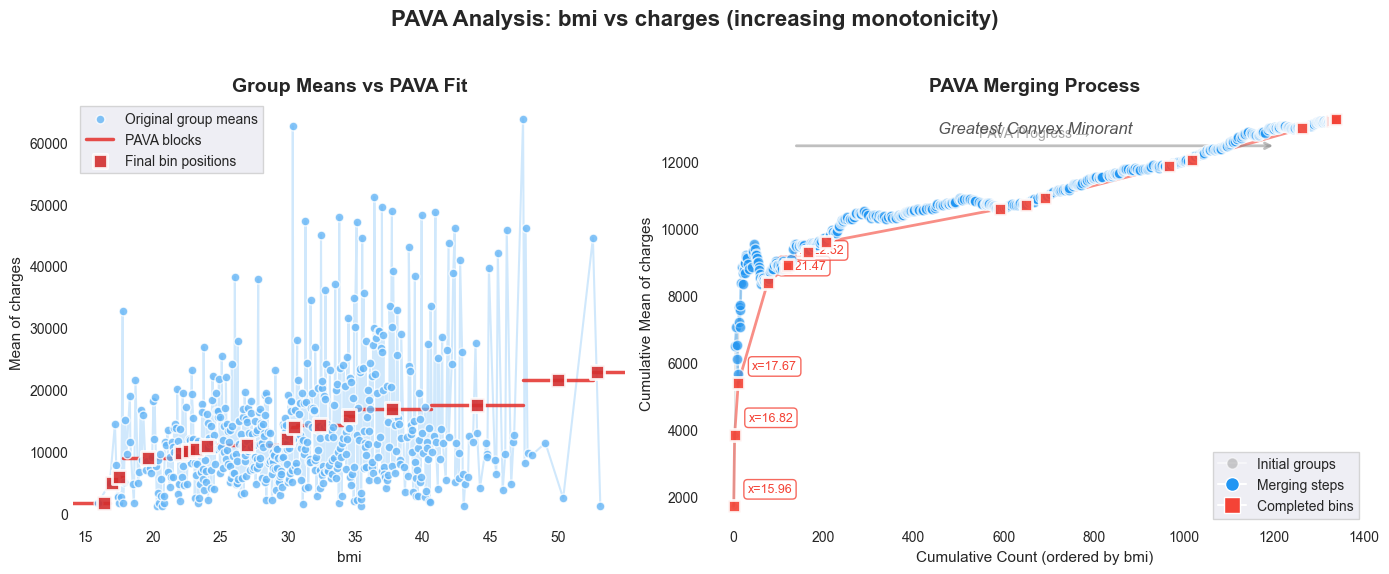


Number of unique BMI values: 548
BMI range: [16.0, 53.1]


In [6]:
# Visualize the PAVA algorithm steps
# This now shows 2 complementary views:
# 1. Group means with PAVA monotonic fit 
# 2. PAVA merging process with "Greatest Convex Minorant" subtitle
fig = plot_pava_comparison(bmi_binner, figsize=(14, 6))
plt.show()

# Get detailed PAVA information
pava_groups = bmi_binner.pava_groups_()
print(f"\nNumber of unique BMI values: {len(pava_groups)}")
print(f"BMI range: [{pava_groups['x'].min():.1f}, {pava_groups['x'].max():.1f}]")

##### 3.1.1 Detailed PAVA Process for Continuous Targets
Let's examine how PAVA forms bins with continuous target variables, showing actual BMI values where bins are created:

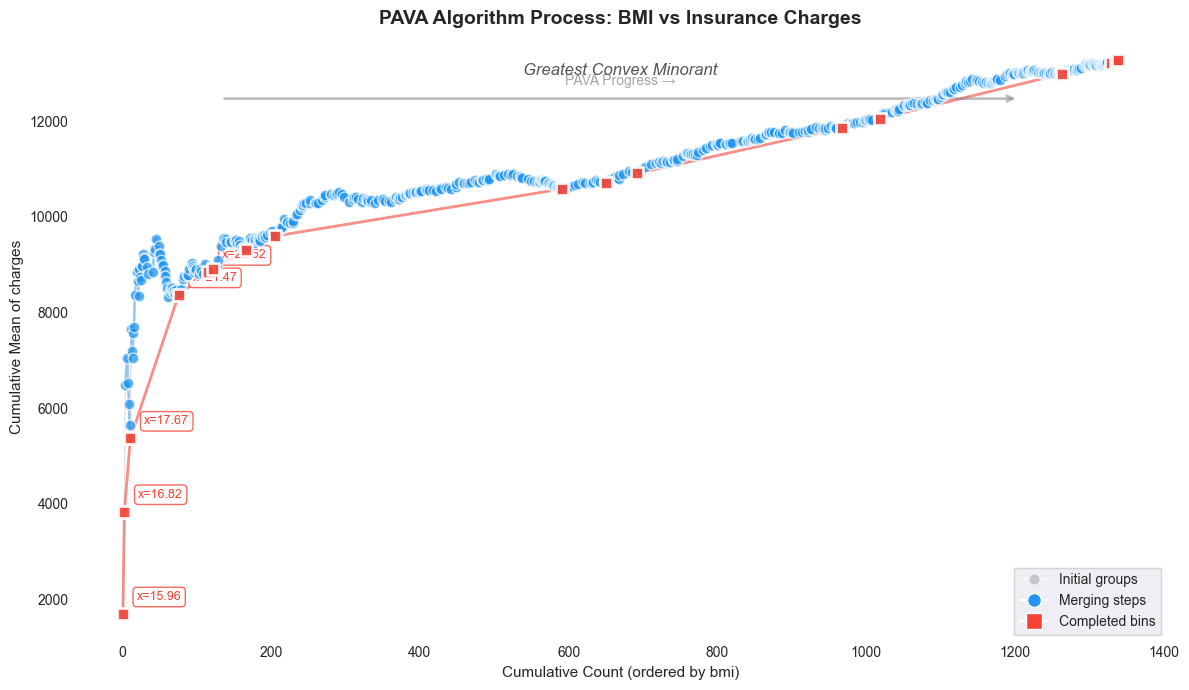


PAVA compressed 548 unique BMI values into 17 monotonic blocks
Red squares show the 17 final bin anchor points
Annotations display actual BMI values where bins are formed


In [7]:
# Show detailed PAVA process for continuous target
fig, ax = plt.subplots(figsize=(12, 7))
groups_df = bmi_binner.pava_groups_()
blocks = bmi_binner.pava_blocks_(as_dict=True)

plot_pava_process(
    groups_df=groups_df,
    blocks=blocks,
    ax=ax,
    title='PAVA Algorithm Process: BMI vs Insurance Charges',
    subtitle='Greatest Convex Minorant',
    x_column='bmi',
    y_column='charges',
    show_annotations=True
)
plt.tight_layout()
plt.show()

print(f"\nPAVA compressed {len(groups_df)} unique BMI values into {len(blocks)} monotonic blocks")
print(f"Red squares show the {len(blocks)} final bin anchor points")
print(f"Annotations display actual BMI values where bins are formed")

##### 3.2 Binning Results

In [8]:
# Get binning summary
summary = bmi_binner.summary_()
print("\nBMI Binning Summary:")
display(summary)

# Note: For continuous targets, there's no WoE/IV


BMI Binning Summary:


,bucket,count,count_pct,sum,mean,std,min,max
0,"(-inf, 22.7)",122,9.118087,1.085666e+06,8898.904692,6509.629209,1241.5650,32734.18630
1,"[22.7, 30.2)",528,39.461883,5.878624e+06,11133.756631,8102.619665,1121.8739,38245.59327
2,"[30.2, 34.1)",317,23.692078,4.507326e+06,14218.693553,13170.007866,1135.9407,62592.87309
3,"[34.1, +inf)",371,27.727952,6.284209e+06,16938.569437,15727.334382,1137.4697,63770.42801


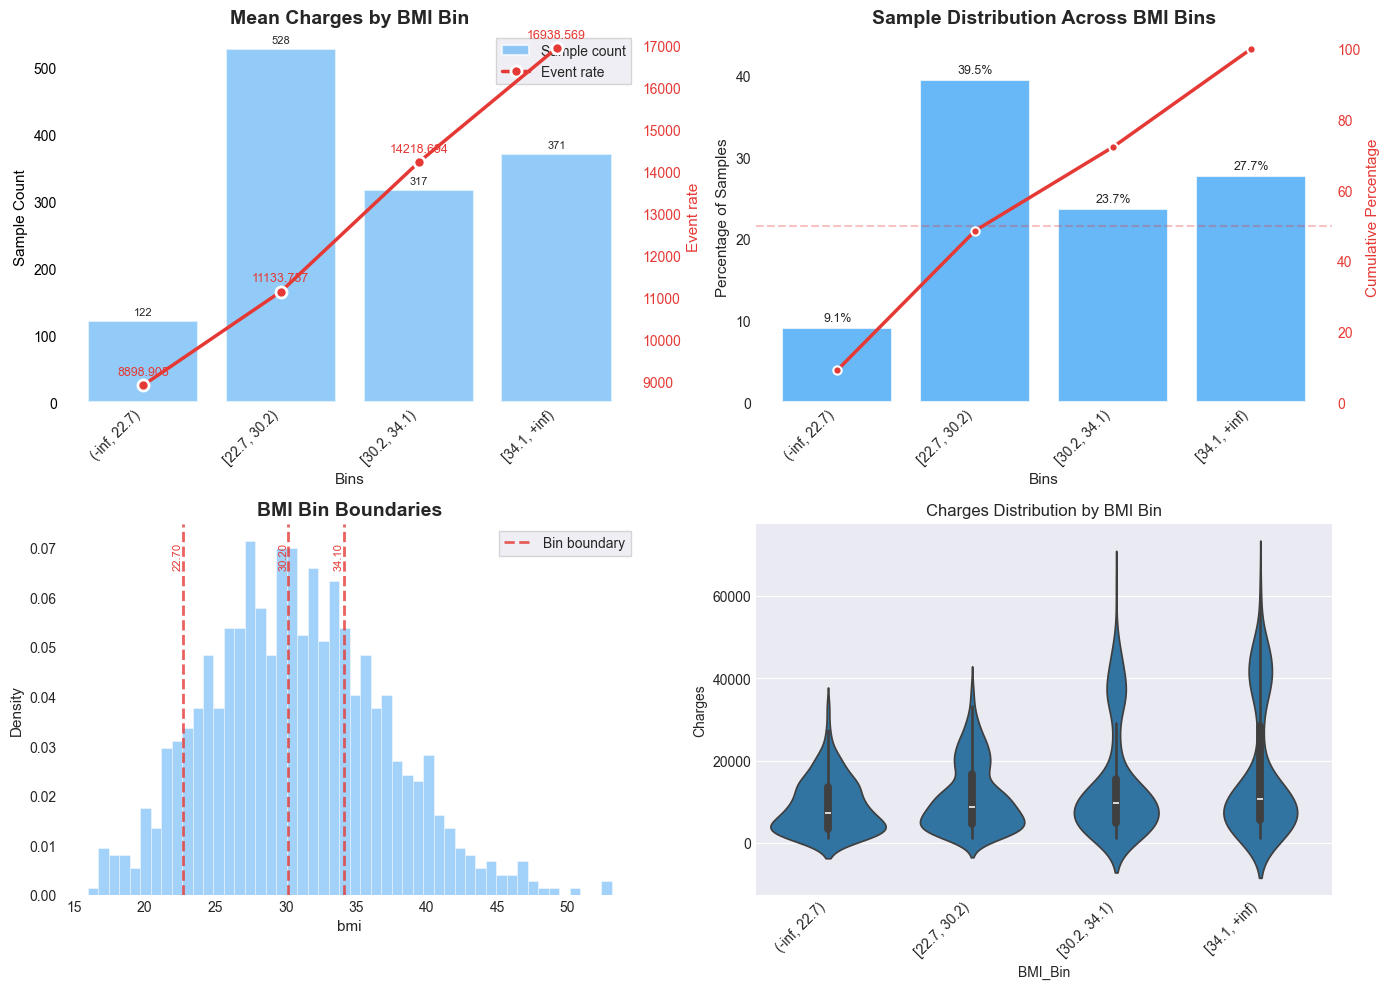

In [9]:
# Comprehensive visualization for continuous target
# Since we don't have WoE for continuous targets, we'll create a custom visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Mean charges by bin
ax1 = axes[0, 0]
plot_event_rate(summary, ax=ax1, title='Mean Charges by BMI Bin', 
                y_format='decimal', show_counts=True)

# Plot 2: Sample distribution
ax2 = axes[0, 1]
plot_sample_distribution(summary, ax=ax2, title='Sample Distribution Across BMI Bins')

# Plot 3: Bin boundaries on data
ax3 = axes[1, 0]
plot_bin_boundaries(bmi_binner, ax=ax3, title='BMI Bin Boundaries', 
                   show_density=True, show_means=False)

# Plot 4: Charges distribution by bin (violin plot)
ax4 = axes[1, 1]
bin_labels = bmi_binner.transform(df['bmi'])
violin_df = pd.DataFrame({'BMI_Bin': bin_labels, 'Charges': df['charges']})
# Filter to numeric bins only
violin_df = violin_df[~violin_df['BMI_Bin'].isin(['Missing', 'Excluded'])]

# Create violin plot
bin_order = summary[~summary['bucket'].str.contains('Missing|Excluded')]['bucket'].tolist()
sns.violinplot(data=violin_df, x='BMI_Bin', y='Charges', order=bin_order, ax=ax4)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha='right')
ax4.set_title('Charges Distribution by BMI Bin')

plt.tight_layout()
plt.show()

##### 4. Monotonic Binning: Age with Different Strategies

2025-08-27 22:48:36 - MOBPY.core.merge - WARNING - Could not satisfy min_samples for 1 bins (reached min_bins=4 limit)


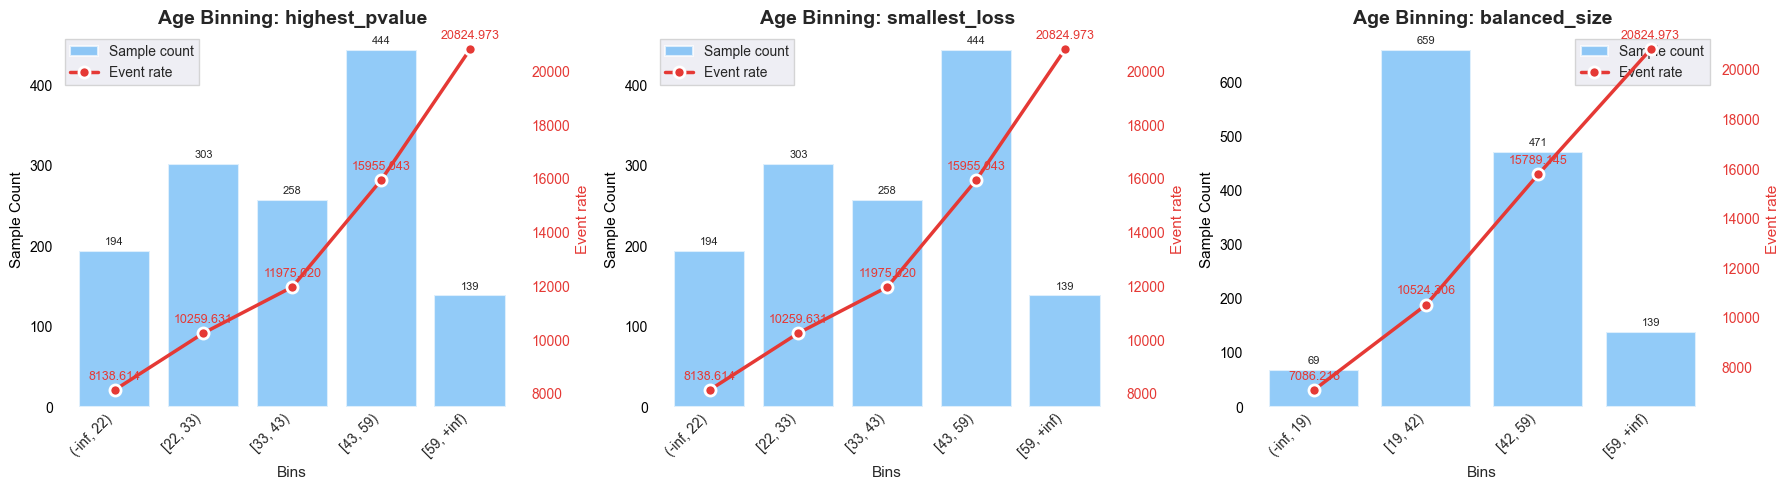


Strategy Comparison:


,Strategy,N_bins,Min_samples,Max_samples,Std_of_means
0,highest_pvalue,5,139,444,5030.617153
1,smallest_loss,5,139,444,5030.617153
2,balanced_size,4,69,659,6024.233196


In [10]:
# Compare different merge strategies on Age
strategies = [MergeStrategy.HIGHEST_PVALUE, MergeStrategy.SMALLEST_LOSS, MergeStrategy.BALANCED_SIZE]
strategy_results = []

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, strategy in enumerate(strategies):
    # Fit binner with different strategy
    age_binner = MonotonicBinner(
        df=df,
        x='age',
        y='charges',
        constraints=BinningConstraints(max_bins=5, min_samples=0.05),
        merge_strategy=strategy
    )
    age_binner.fit()
    
    # Get results
    summary = age_binner.summary_()
    strategy_results.append({
        'Strategy': strategy.value,
        'N_bins': len(summary[~summary['bucket'].str.contains('Missing|Excluded')]),
        'Min_samples': summary['count'].min(),
        'Max_samples': summary['count'].max(),
        'Std_of_means': summary['mean'].std()
    })
    
    # Plot
    plot_event_rate(summary, ax=axes[idx], 
                   title=f'Age Binning: {strategy.value}',
                   y_format='decimal', show_counts=True)

plt.tight_layout()
plt.show()

# Compare strategies
strategy_df = pd.DataFrame(strategy_results)
print("\nStrategy Comparison:")
display(strategy_df)

##### 5. Advanced: Binning with Log-Transformed Target
Since insurance charges are highly skewed, let's try binning with log-transformed target:

2025-08-27 22:48:37 - MOBPY.core.merge - WARNING - Could not satisfy min_samples for 1 bins (reached min_bins=4 limit)


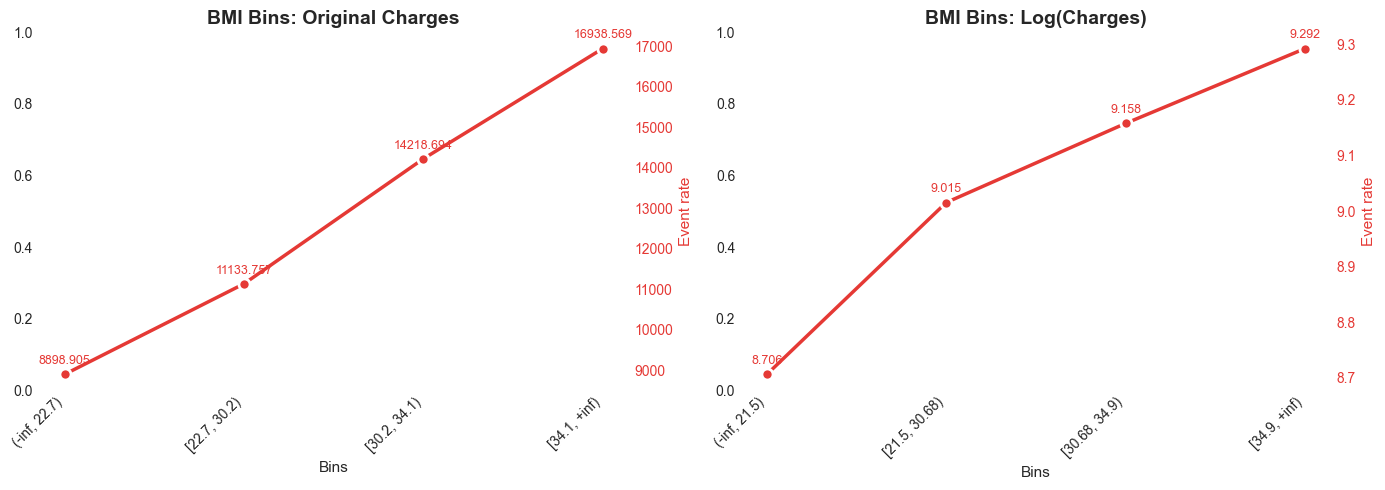

In [11]:
# Create log-transformed target
df['log_charges'] = np.log1p(df['charges'])

# Bin BMI with log charges
log_binner = MonotonicBinner(
    df=df,
    x='bmi',
    y='log_charges',
    constraints=BinningConstraints(max_bins=5, min_samples=0.05)
)
log_binner.fit()

# Compare with original scale
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Original scale
summary_orig = bmi_binner.summary_()
plot_event_rate(summary_orig, ax=ax1, title='BMI Bins: Original Charges',
               y_format='decimal', show_counts=False)

# Log scale
summary_log = log_binner.summary_()
plot_event_rate(summary_log, ax=ax2, title='BMI Bins: Log(Charges)',
               y_format='decimal', show_counts=False)

plt.tight_layout()
plt.show()

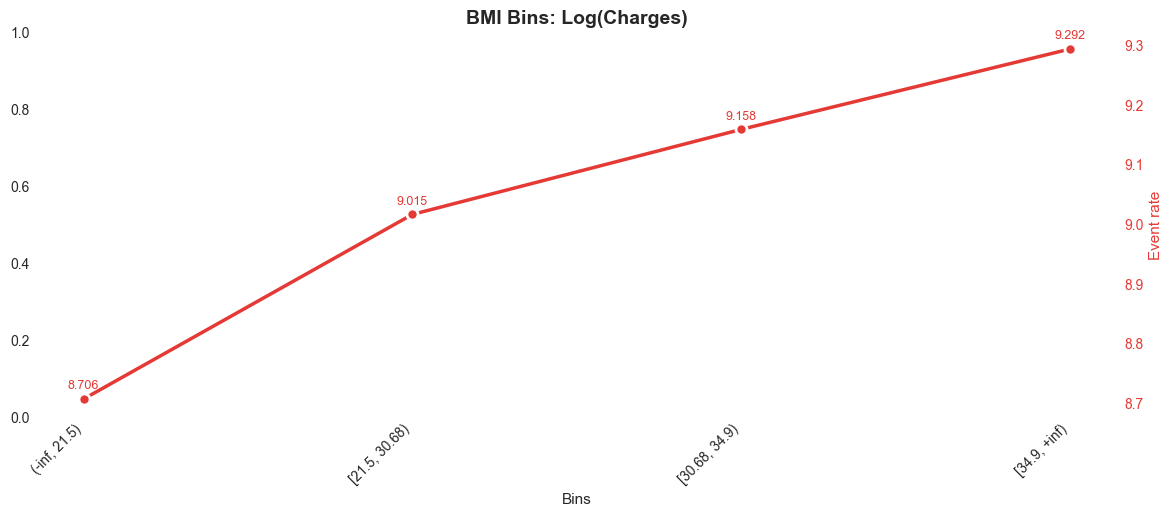

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
summary_log = log_binner.summary_()
plot_event_rate(summary_log, ax=ax, title='BMI Bins: Log(Charges)',
               y_format='decimal', show_counts=False)
plt.show()

##### 6. Multi-Feature Binning Analysis

2025-08-27 22:48:37 - MOBPY.core.merge - WARNING - Could not satisfy min_samples for 1 bins (reached min_bins=4 limit)
2025-08-27 22:48:37 - MOBPY.core.merge - WARNING - Could not satisfy min_samples for 2 bins (reached min_bins=4 limit)
2025-08-27 22:48:37 - MOBPY.core.merge - WARNING - Could not satisfy min_samples for 1 bins (reached min_bins=4 limit)


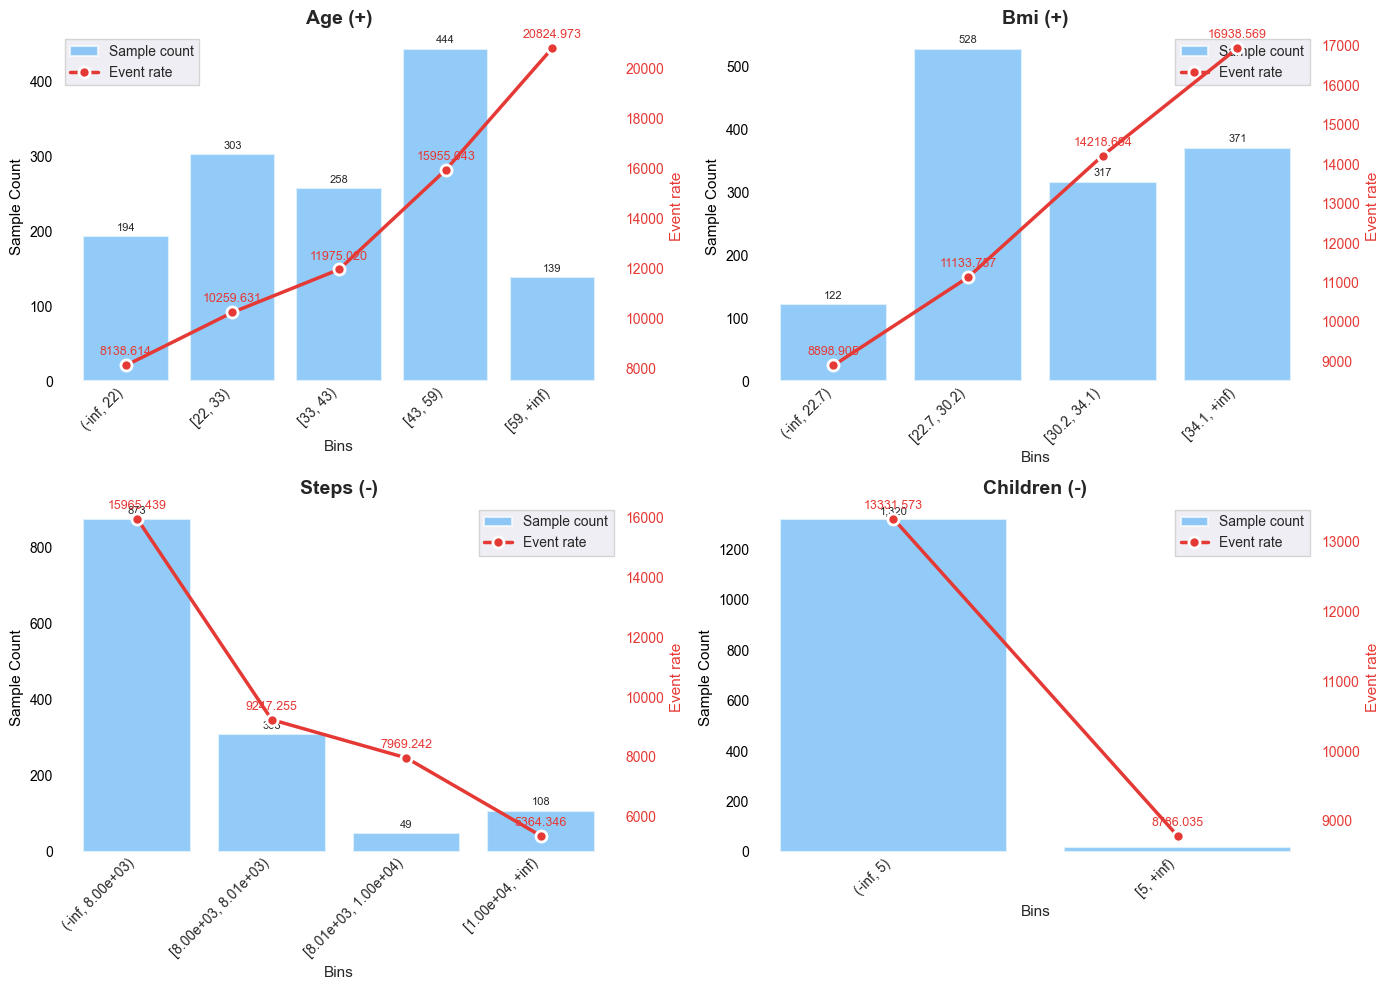


Multi-Feature Binning Results:


,Feature,Direction,N_bins,Correlation,Mean_range
0,age,+,5,0.299008,12686.359077
2,steps,-,4,-0.305570,10601.093601
1,bmi,+,4,0.198341,8039.664745
3,children,-,2,0.067998,4545.537750


In [13]:
# Bin all numeric features and analyze monotonic patterns
features_to_bin = ['age', 'bmi', 'steps', 'children']
binning_results = []

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, feature in enumerate(features_to_bin):
    # Fit binner
    binner = MonotonicBinner(
        df=df,
        x=feature,
        y='charges',
        constraints=BinningConstraints(max_bins=5, min_samples=0.05)
    )
    binner.fit()
    
    # Store results
    summary = binner.summary_()
    binning_results.append({
        'Feature': feature,
        'Direction': binner.resolved_sign_,
        'N_bins': len(binner.bins_()),
        'Correlation': df[feature].corr(df['charges']),
        'Mean_range': summary['mean'].max() - summary['mean'].min()
    })
    
    # Plot
    plot_event_rate(summary, ax=axes[idx], 
                   title=f'{feature.capitalize()} ({binner.resolved_sign_})',
                   y_format='decimal', show_counts=True)

plt.tight_layout()
plt.show()

# Display results
results_df = pd.DataFrame(binning_results)
print("\nMulti-Feature Binning Results:")
display(results_df.sort_values('Mean_range', ascending=False))

##### 6.1 PAVA Process Comparison for Different Features
Let's compare how PAVA works for features with different monotonic relationships:

2025-08-27 22:48:38 - MOBPY.core.merge - WARNING - Could not satisfy min_samples for 2 bins (reached min_bins=4 limit)


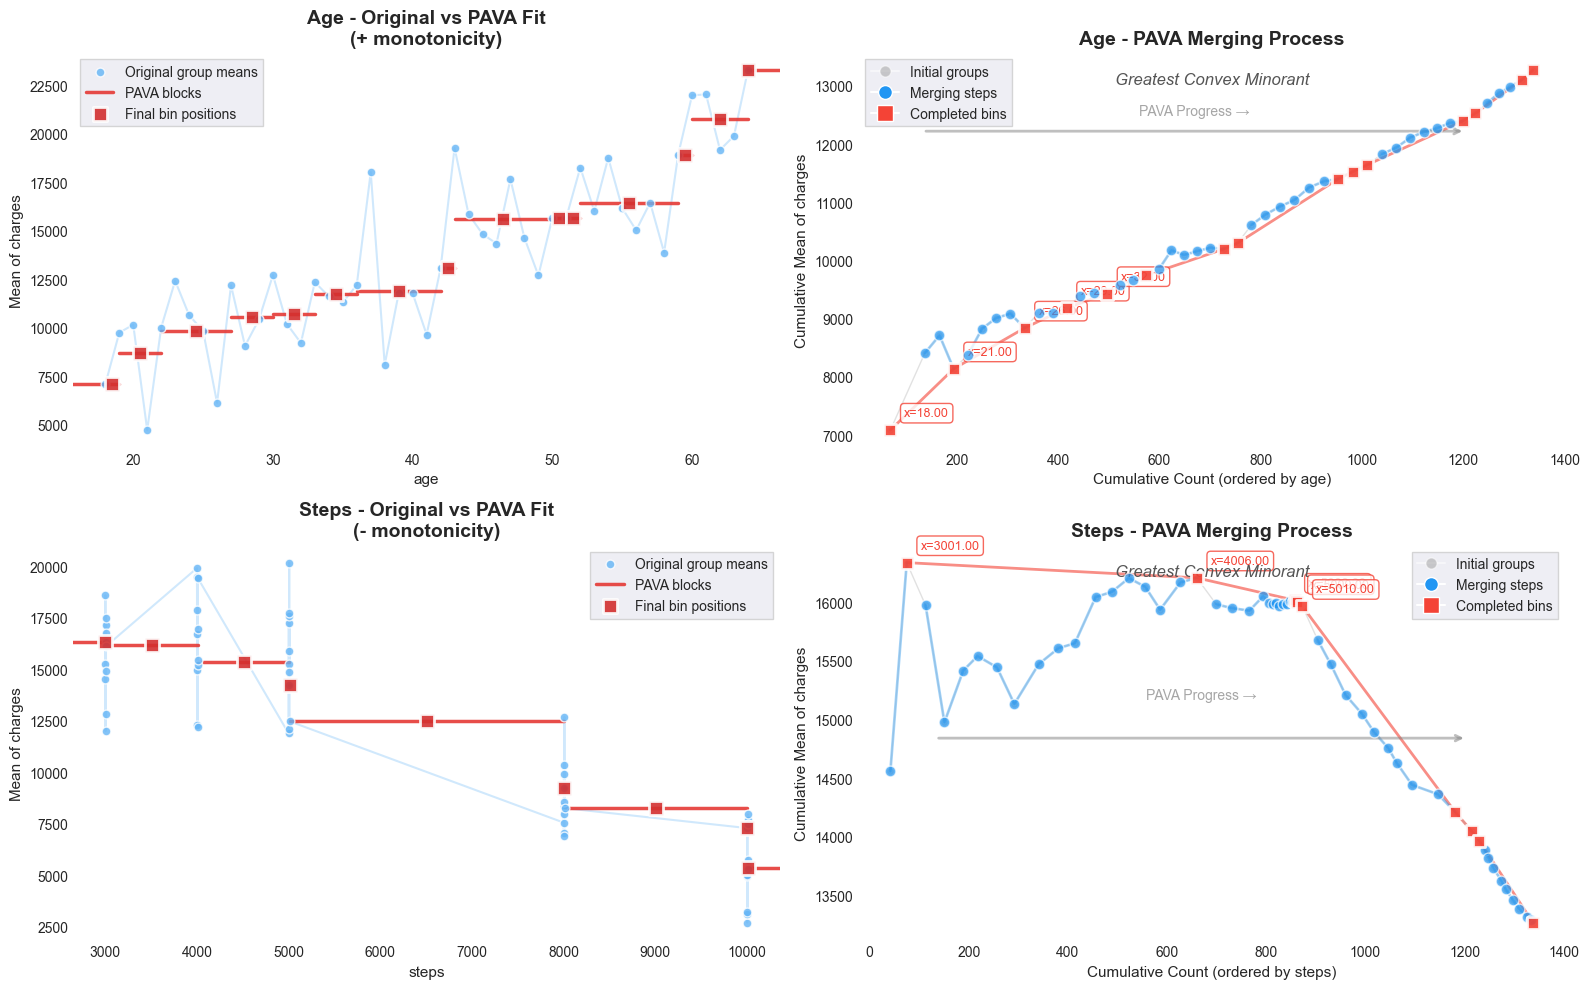


Observations:
- Age shows positive monotonicity (older → higher charges)
- Steps shows negative monotonicity (more steps → lower charges)
- Red squares indicate final bin positions with actual feature values
- PAVA merging process varies based on the underlying data pattern


In [14]:
# Compare PAVA process for two contrasting features
features_to_compare = ['age', 'steps']
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

for idx, feature in enumerate(features_to_compare):
    # Fit binner
    binner = MonotonicBinner(
        df=df,
        x=feature,
        y='charges',
        constraints=BinningConstraints(max_bins=5, min_samples=0.05)
    )
    binner.fit()
    
    # Get PAVA data
    groups_df = binner.pava_groups_()
    blocks = binner.pava_blocks_(as_dict=True)
    
    # Plot GCM
    plot_gcm(
        groups_df=groups_df,
        blocks=blocks,
        ax=axes[idx, 0],
        title=f'{feature.capitalize()} - Original vs PAVA Fit\n({binner.resolved_sign_} monotonicity)',
        x_column=feature,
        y_column='charges'
    )
    
    # Plot PAVA process
    plot_pava_process(
        groups_df=groups_df,
        blocks=blocks,
        ax=axes[idx, 1],
        title=f'{feature.capitalize()} - PAVA Merging Process',
        subtitle='Greatest Convex Minorant',
        x_column=feature,
        y_column='charges',
        show_annotations=True
    )

plt.tight_layout()
plt.show()

print("\nObservations:")
print("- Age shows positive monotonicity (older → higher charges)")
print("- Steps shows negative monotonicity (more steps → lower charges)")
print("- Red squares indicate final bin positions with actual feature values")
print("- PAVA merging process varies based on the underlying data pattern")

##### 7. Creating a Binned Dataset for Modeling

In [15]:
# Transform all features to binned versions
binned_features = {}

for feature in features_to_bin:
    # Fit binner
    binner = MonotonicBinner(
        df=df,
        x=feature,
        y='charges',
        constraints=BinningConstraints(max_bins=5, min_samples=0.05)
    )
    binner.fit()
    
    # Create binned versions
    binned_features[f'{feature}_bin'] = binner.transform(df[feature])
    binned_features[f'{feature}_left'] = binner.transform(df[feature], assign='left')
    binned_features[f'{feature}_right'] = binner.transform(df[feature], assign='right')

# Create new dataframe with binned features
df_binned = pd.DataFrame(binned_features)
print("Binned features dataset:")
display(df_binned.head(10))

2025-08-27 22:48:39 - MOBPY.core.merge - WARNING - Could not satisfy min_samples for 1 bins (reached min_bins=4 limit)
2025-08-27 22:48:39 - MOBPY.core.merge - WARNING - Could not satisfy min_samples for 2 bins (reached min_bins=4 limit)
2025-08-27 22:48:39 - MOBPY.core.merge - WARNING - Could not satisfy min_samples for 1 bins (reached min_bins=4 limit)
Binned features dataset:


,age_bin,age_left,age_right,bmi_bin,bmi_left,bmi_right,steps_bin,steps_left,steps_right,children_bin,children_left,children_right
0,"(-inf, 22)",-inf,22.0,"[22.7, 30.2)",22.705,30.200,"(-inf, 8.00e+03)",-inf,8000.0,"(-inf, 5)",-inf,5.0
1,"(-inf, 22)",-inf,22.0,"[30.2, 34.1)",30.200,34.105,"(-inf, 8.00e+03)",-inf,8000.0,"(-inf, 5)",-inf,5.0
2,"[22, 33)",22.0,33.0,"[30.2, 34.1)",30.200,34.105,"(-inf, 8.00e+03)",-inf,8000.0,"(-inf, 5)",-inf,5.0
3,"[33, 43)",33.0,43.0,"[22.7, 30.2)",22.705,30.200,"[1.00e+04, +inf)",10001.0,inf,"(-inf, 5)",-inf,5.0
4,"[22, 33)",22.0,33.0,"[22.7, 30.2)",22.705,30.200,"[8.01e+03, 1.00e+04)",8010.0,10001.0,"(-inf, 5)",-inf,5.0
5,"[22, 33)",22.0,33.0,"[22.7, 30.2)",22.705,30.200,"[8.00e+03, 8.01e+03)",8000.0,8010.0,"(-inf, 5)",-inf,5.0
6,"[43, 59)",43.0,59.0,"[30.2, 34.1)",30.200,34.105,"(-inf, 8.00e+03)",-inf,8000.0,"(-inf, 5)",-inf,5.0
7,"[33, 43)",33.0,43.0,"[22.7, 30.2)",22.705,30.200,"[8.00e+03, 8.01e+03)",8000.0,8010.0,"(-inf, 5)",-inf,5.0
8,"[33, 43)",33.0,43.0,"[22.7, 30.2)",22.705,30.200,"[8.00e+03, 8.01e+03)",8000.0,8010.0,"(-inf, 5)",-inf,5.0
9,"[59, +inf)",59.0,inf,"[22.7, 30.2)",22.705,30.200,"(-inf, 8.00e+03)",-inf,8000.0,"(-inf, 5)",-inf,5.0


##### 8. Stability Analysis with Cross-Validation

In [16]:
from sklearn.model_selection import KFold

# Perform k-fold stability analysis
kf = KFold(n_splits=5, shuffle=True, random_state=42)
stability_results = []

for fold, (train_idx, test_idx) in enumerate(kf.split(df)):
    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]
    
    # Fit on train
    cv_binner = MonotonicBinner(
        df=train_df,
        x='bmi',
        y='charges',
        constraints=BinningConstraints(max_bins=5, min_samples=0.05)
    )
    cv_binner.fit()
    
    # Evaluate on test
    train_summary = cv_binner.summary_()
    
    # Calculate test statistics
    test_bins = cv_binner.transform(test_df['bmi'])
    for bin_label in train_summary['bucket']:
        if not bin_label.startswith('Missing'):
            mask = test_bins == bin_label
            if mask.sum() > 0:
                stability_results.append({
                    'Fold': fold + 1,
                    'Bin': bin_label,
                    'Train_mean': train_summary[train_summary['bucket'] == bin_label]['mean'].iloc[0],
                    'Test_mean': test_df.loc[mask, 'charges'].mean(),
                    'Test_count': mask.sum()
                })

# Analyze stability
stability_df = pd.DataFrame(stability_results)
stability_summary = stability_df.groupby('Bin').agg({
    'Train_mean': 'mean',
    'Test_mean': 'mean',
    'Test_count': 'mean'
}).reset_index()

stability_summary['Diff_%'] = abs(stability_summary['Test_mean'] - stability_summary['Train_mean']) / stability_summary['Train_mean'] * 100

print("\nCross-Validation Stability Analysis:")
display(stability_summary)
print(f"\nAverage difference: {stability_summary['Diff_%'].mean():.2f}%")

2025-08-27 22:48:43 - MOBPY.core.merge - WARNING - Could not satisfy min_samples for 1 bins (reached min_bins=4 limit)
2025-08-27 22:48:43 - MOBPY.core.merge - WARNING - Could not satisfy min_samples for 1 bins (reached min_bins=4 limit)
2025-08-27 22:48:43 - MOBPY.core.merge - WARNING - Could not satisfy min_samples for 1 bins (reached min_bins=4 limit)
2025-08-27 22:48:43 - MOBPY.core.merge - WARNING - Could not satisfy min_samples for 2 bins (reached min_bins=4 limit)
2025-08-27 22:48:43 - MOBPY.core.merge - WARNING - Could not satisfy min_samples for 1 bins (reached min_bins=4 limit)

Cross-Validation Stability Analysis:


,Bin,Train_mean,Test_mean,Test_count,Diff_%
0,"(-inf, 21.5)",8139.989483,9170.942215,17.000000,12.665283
1,"(-inf, 22.42)",8891.448548,8475.076226,25.000000,4.682840
2,"(-inf, 22.88)",8743.429613,9973.004044,25.000000,14.062839
3,"(-inf, 23.98)",9510.685212,9434.211383,40.000000,0.804083
4,"(-inf, 30.2)",10455.459623,11648.659044,141.000000,11.412214
5,"[21.5, 29.6)",10851.575329,11240.602641,95.000000,3.584985
6,"[22.42, 30.36)",11097.683151,11547.788306,112.000000,4.055848
7,"[22.88, 29.7)",11110.861228,10839.782826,85.000000,2.439760
8,"[23.98, 30.2)",11228.035268,11080.121367,89.000000,1.317362
9,"[29.6, 34.1)",14346.405845,11737.241684,76.000000,18.186884



Average difference: 12.48%


##### 9. Greatest Convex Minorant Visualization
Let's examine the GCM in detail for the steps feature, which shows interesting monotonic behavior:

2025-08-27 22:48:43 - MOBPY.core.merge - WARNING - Could not satisfy min_samples for 2 bins (reached min_bins=4 limit)


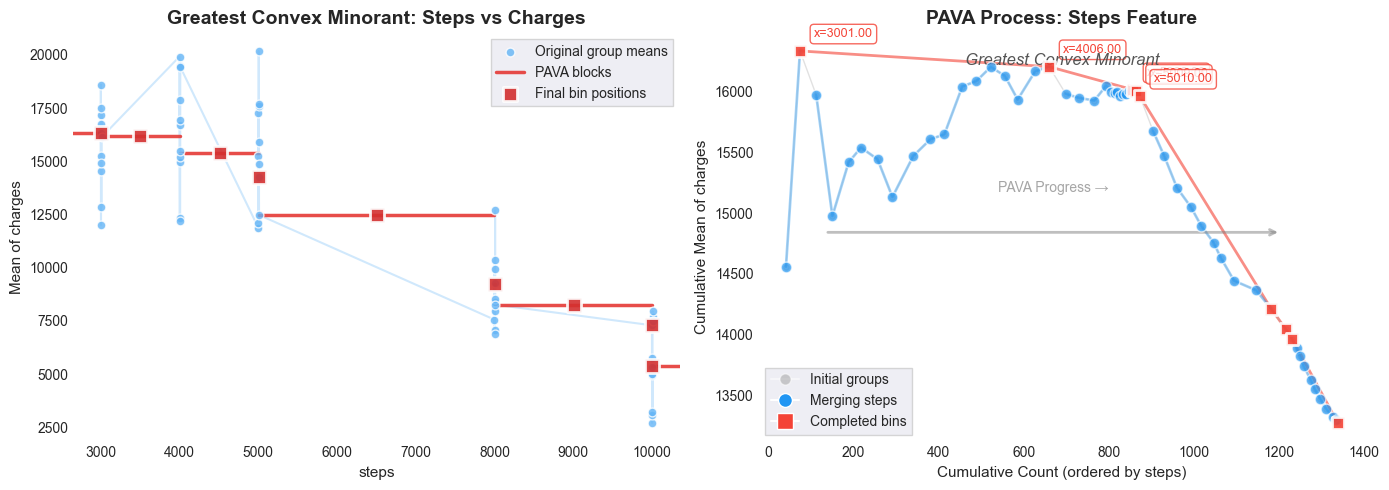


PAVA compression: 55 unique step values → 9 monotonic blocks
Monotonicity direction: - (more steps → lower charges)
Final binning created 4 bins after constraint application


In [17]:
# Deep dive into PAVA for steps feature
steps_binner = MonotonicBinner(
    df=df,
    x='steps',
    y='charges',
    constraints=BinningConstraints(max_bins=6, min_samples=0.05)
)
steps_binner.fit()

# Get PAVA components
groups = steps_binner.pava_groups_()
blocks = steps_binner.pava_blocks_(as_dict=True)

# Create detailed PAVA visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# GCM plot showing original means vs PAVA fit
plot_gcm(
    groups, 
    blocks, 
    ax=ax1, 
    title='Greatest Convex Minorant: Steps vs Charges',
    x_column='steps',
    y_column='charges',
    show_means=True,
    show_blocks=True,
    show_block_points=True
)

# PAVA process plot
plot_pava_process(
    groups,
    blocks,
    ax=ax2,
    title='PAVA Process: Steps Feature',
    subtitle='Greatest Convex Minorant',
    x_column='steps',
    y_column='charges',
    show_annotations=True
)

plt.tight_layout()
plt.show()

print(f"\nPAVA compression: {len(groups)} unique step values → {len(blocks)} monotonic blocks")
print(f"Monotonicity direction: {steps_binner.resolved_sign_} (more steps → lower charges)")
print(f"Final binning created {len(steps_binner.bins_())} bins after constraint application")

##### 10. Key Insights and Recommendations

In [18]:
# Get comprehensive diagnostics for all features
print("Comprehensive Binning Analysis for Continuous Target:\n")

for feature in features_to_bin:
    binner = MonotonicBinner(
        df=df,
        x=feature,
        y='charges',
        constraints=BinningConstraints(max_bins=5, min_samples=0.05)
    )
    binner.fit()
    
    diag = binner.get_diagnostics()
    print(f"{feature.upper()}:")
    print(f"  Monotonicity: {diag['resolved_sign']}")
    print(f"  PAVA compression: {diag['pava_diagnostics']['compression_ratio']:.2f}x")
    print(f"  Final bins: {diag['n_final_bins']}")
    print(f"  Constraints satisfied: {diag['constraints_satisfied']}")
    print()

Comprehensive Binning Analysis for Continuous Target:

AGE:
  Monotonicity: +
  PAVA compression: 3.13x
  Final bins: 5
  Constraints satisfied: {'max_bins': True, 'min_bins': True, 'min_samples': True}

2025-08-27 22:48:43 - MOBPY.core.merge - WARNING - Could not satisfy min_samples for 1 bins (reached min_bins=4 limit)
BMI:
  Monotonicity: +
  PAVA compression: 32.24x
  Final bins: 4
  Constraints satisfied: {'max_bins': True, 'min_bins': True, 'min_samples': True}

2025-08-27 22:48:43 - MOBPY.core.merge - WARNING - Could not satisfy min_samples for 2 bins (reached min_bins=4 limit)
STEPS:
  Monotonicity: -
  PAVA compression: 6.11x
  Final bins: 4
  Constraints satisfied: {'max_bins': True, 'min_bins': True, 'min_samples': False}

2025-08-27 22:48:43 - MOBPY.core.merge - WARNING - Could not satisfy min_samples for 1 bins (reached min_bins=4 limit)
CHILDREN:
  Monotonicity: -
  PAVA compression: 3.00x
  Final bins: 2
  Constraints satisfied: {'max_bins': True, 'min_bins': False, 'min